In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special
import jax
import duckdb

import imprint as ip
import confirm
import confirm.adagrid as ada
from confirm.adagrid.const import MAX_STEP
import confirm.cloud.clickhouse as ch

ip.setup_nb()

job_name_prefix = "wd41"
service = "PROD"

ddb_path = Path(confirm.__file__).parent.parent.joinpath(f"{job_name_prefix}.db")
use_clickhouse = False
if ddb_path.exists():
    try:
        ddb = ada.DuckDBTiles(duckdb.connect(str(ddb_path), read_only=True))

        def query(q):
            return ddb.con.query(q).df()

    except Exception:
        use_clickhouse = True
else:
    use_clickhouse = True

if use_clickhouse:
    client = ch.get_ch_client(service=service)
    jobs = [job_name for job_name in ch.list_dbs(client) if job_name.startswith(job_name_prefix)]
    jobs.sort()
    job_name = jobs[-1]

    ch_db = ch.ClickhouseTiles.connect(job_name, service=service)
    query = ch_db.query

2023-04-06 09:00:40,640 - imprint - DEBUG 
Enabling 64-bit floats in JAX.
2023-04-06 09:00:40,781 - confirm.cloud.clickhouse - INFO 
Clickhouse config: default@retpwkzwje.us-east-1.aws.clickhouse.cloud:8443/None
2023-04-06 09:01:20,958 - confirm.cloud.clickhouse - INFO 
Clickhouse config: default@retpwkzwje.us-east-1.aws.clickhouse.cloud:8443/None
2023-04-06 09:01:21,119 - confirm.cloud.clickhouse - DEBUG 
Command took 0.019616127014160156 seconds
create database if not exists wd41_4d_20230406_032336
2023-04-06 09:01:21,120 - confirm.cloud.clickhouse - INFO 
Connected to job wd41_4d_20230406_032336


In [2]:
query('select count(*)/1000000 from results')

2023-04-06 09:01:21,208 - confirm.cloud.clickhouse - DEBUG 
Query took 0.0384821891784668 seconds
select count(*)/1000000 from results


,"divide(count(), 1000000)"
0,62.71824


In [3]:
query('select sum(K)/1e12 from results')

2023-04-06 09:01:27,766 - confirm.cloud.clickhouse - DEBUG 
Query took 6.511709928512573 seconds
select sum(K)/1e12 from results


,"divide(sum(K), 1000000000000.)"
0,31.344738


In [5]:
query('select median(K) from results')

2023-04-06 09:02:29,683 - confirm.cloud.clickhouse - DEBUG 
Query took 0.3952779769897461 seconds
select median(K) from results


,median(K)
0,524288.0


In [119]:
dim = len(
    [c for c in query("select * from results limit 1").columns if c.startswith("theta")]
)
n_steps = query("select max(step_id) from results").iloc[0][0] + 1
dim, n_steps


2023-04-05 11:13:47,824 - confirm.cloud.clickhouse - DEBUG 
Query took 0.18230915069580078 seconds
select * from results limit 1
2023-04-05 11:13:47,908 - confirm.cloud.clickhouse - DEBUG 
Query took 0.08385705947875977 seconds
select max(step_id) from results


(4, 23)

In [91]:
for m in query("select * from logs where message LIKE '%Command took%'")['message'].values:
    print(m)

2023-04-05 10:12:54,876 - confirm.cloud.clickhouse - DEBUG 
Query took 0.18486380577087402 seconds
select * from logs where message LIKE '%Command took%'
Command took 0.41380977630615234 seconds

        CREATE TABLE IF NOT EXISTS done (step_id Int64,packet_id Int64,id UInt64,active Int64,active_at_birth Int64,refine Int64,deepen Int64,split Int64)
        ENGINE = MergeTree()
        PARTITION BY (active_at_birth, active)
        ORDER BY (step_id)
        
Command took 0.6799318790435791 seconds

        CREATE TABLE IF NOT EXISTS config (model_seed Int64,alpha Float64,init_K Int64,n_K_double Int64,bootstrap_seed Int64,nB Int64,tile_batch_size Nullable(String),grid_target Float64,bias_target Float64,std_target Float64,calibration_min_idx Int64,n_steps Int64,timeout Int64,step_size Int64,packet_size Int64,n_parallel_steps Int64,record_system Boolean,clickhouse_service Nullable(String),job_name_prefix Nullable(String),job_name Nullable(String),use_clickhouse Boolean,update_software_env

In [159]:
for m in query("select * from logs where message LIKE '%Query took%'")['message'].values:
    print(m)

2023-04-05 13:19:34,855 - confirm.cloud.clickhouse - DEBUG 
Query took 0.4503011703491211 seconds
select * from logs where message LIKE '%Query took%'
Query took 0.026094913482666016 seconds
select * from done limit 0
Query took 0.04215812683105469 seconds
select * from config limit 0
Query took 0.02961897850036621 seconds
select * from logs limit 0
Query took 0.07488298416137695 seconds

                        select count(*) from information_schema.tables
                            where table_schema = 'wd41_4d_20230405_094933'
                                and table_name = 'results'
                        
Query took 0.08177375793457031 seconds

                        select count(*) from information_schema.tables
                            where table_schema = 'wd41_4d_20230405_094933'
                                and table_name = 'results'
                        
Query took 0.02301621437072754 seconds

                        select count(*) from information_schema.tabl

## Performance

In [18]:
import json

reports = [json.loads(v) for v in query("select * from reports")["json"].values]
report_df = pd.DataFrame(reports)
working_reports = report_df[report_df["status"] == "WORKING"].dropna(axis=1, how="all")
new_step_reports = report_df[(report_df["status"] == "NEW_STEP") | (report_df['status'] == 'CONVERGED')].dropna(
    axis=1, how="all"
)
new_step_reports.set_index("step_id", inplace=True)
new_step_reports.sort_index(inplace=True)


2023-04-06 09:06:44,584 - confirm.cloud.clickhouse - DEBUG 
Query took 2.4593889713287354 seconds
select * from reports


In [7]:
min_runtime_per_sim_ns = working_reports["runtime_per_sim_ns"].min()
min_runtime_per_sim_ns = 25

In [8]:
from matplotlib.gridspec import GridSpec

max_step = working_reports['step_id'].max()
min_step = max_step - 8
color_list = ["k", "r", "b", "m"]
offset = report_df["start_time"].min()

step_id = working_reports["step_id"]
include = (step_id >= min_step) & (step_id <= max_step)
df = working_reports[include][
    ['n_total_sims', "sim_start_time", "sim_done_time", "start_time", "done_time", "step_id", 'runtime_per_sim_ns']
].copy()
df.sort_values(by=["sim_start_time"], inplace=True)
df["adjusted_start_time"] = df["start_time"] - offset
df["adjusted_done_time"] = df["done_time"] - offset
df["adjusted_sim_start_time"] = df["sim_start_time"] - offset
df["adjusted_sim_done_time"] = df["sim_done_time"] - offset
min_time = df["adjusted_start_time"].min() - 10
max_time = df["adjusted_done_time"].max() + 10
df['sims_per_sec'] = 1e9 / df['runtime_per_sim_ns']

df["positions"] = (df.groupby("step_id").cumcount()) / 10.0
df["packet_linelengths"] = df["done_time"] - df["start_time"]
df["packet_lineoffsets"] = df["adjusted_start_time"] + df["packet_linelengths"] * 0.5
df["packet_linewidths"] = 1

df["positions"] = (df.groupby("step_id").cumcount()) / 10.0
df["linelengths"] = df["sim_done_time"] - df["sim_start_time"]
df["lineoffsets"] = (
    df["sim_start_time"] - report_df["start_time"].min() + df["linelengths"] * 0.5
)
df["colors"] = np.array(color_list)[df["step_id"] % len(color_list)]
df["linewidths"] = 5

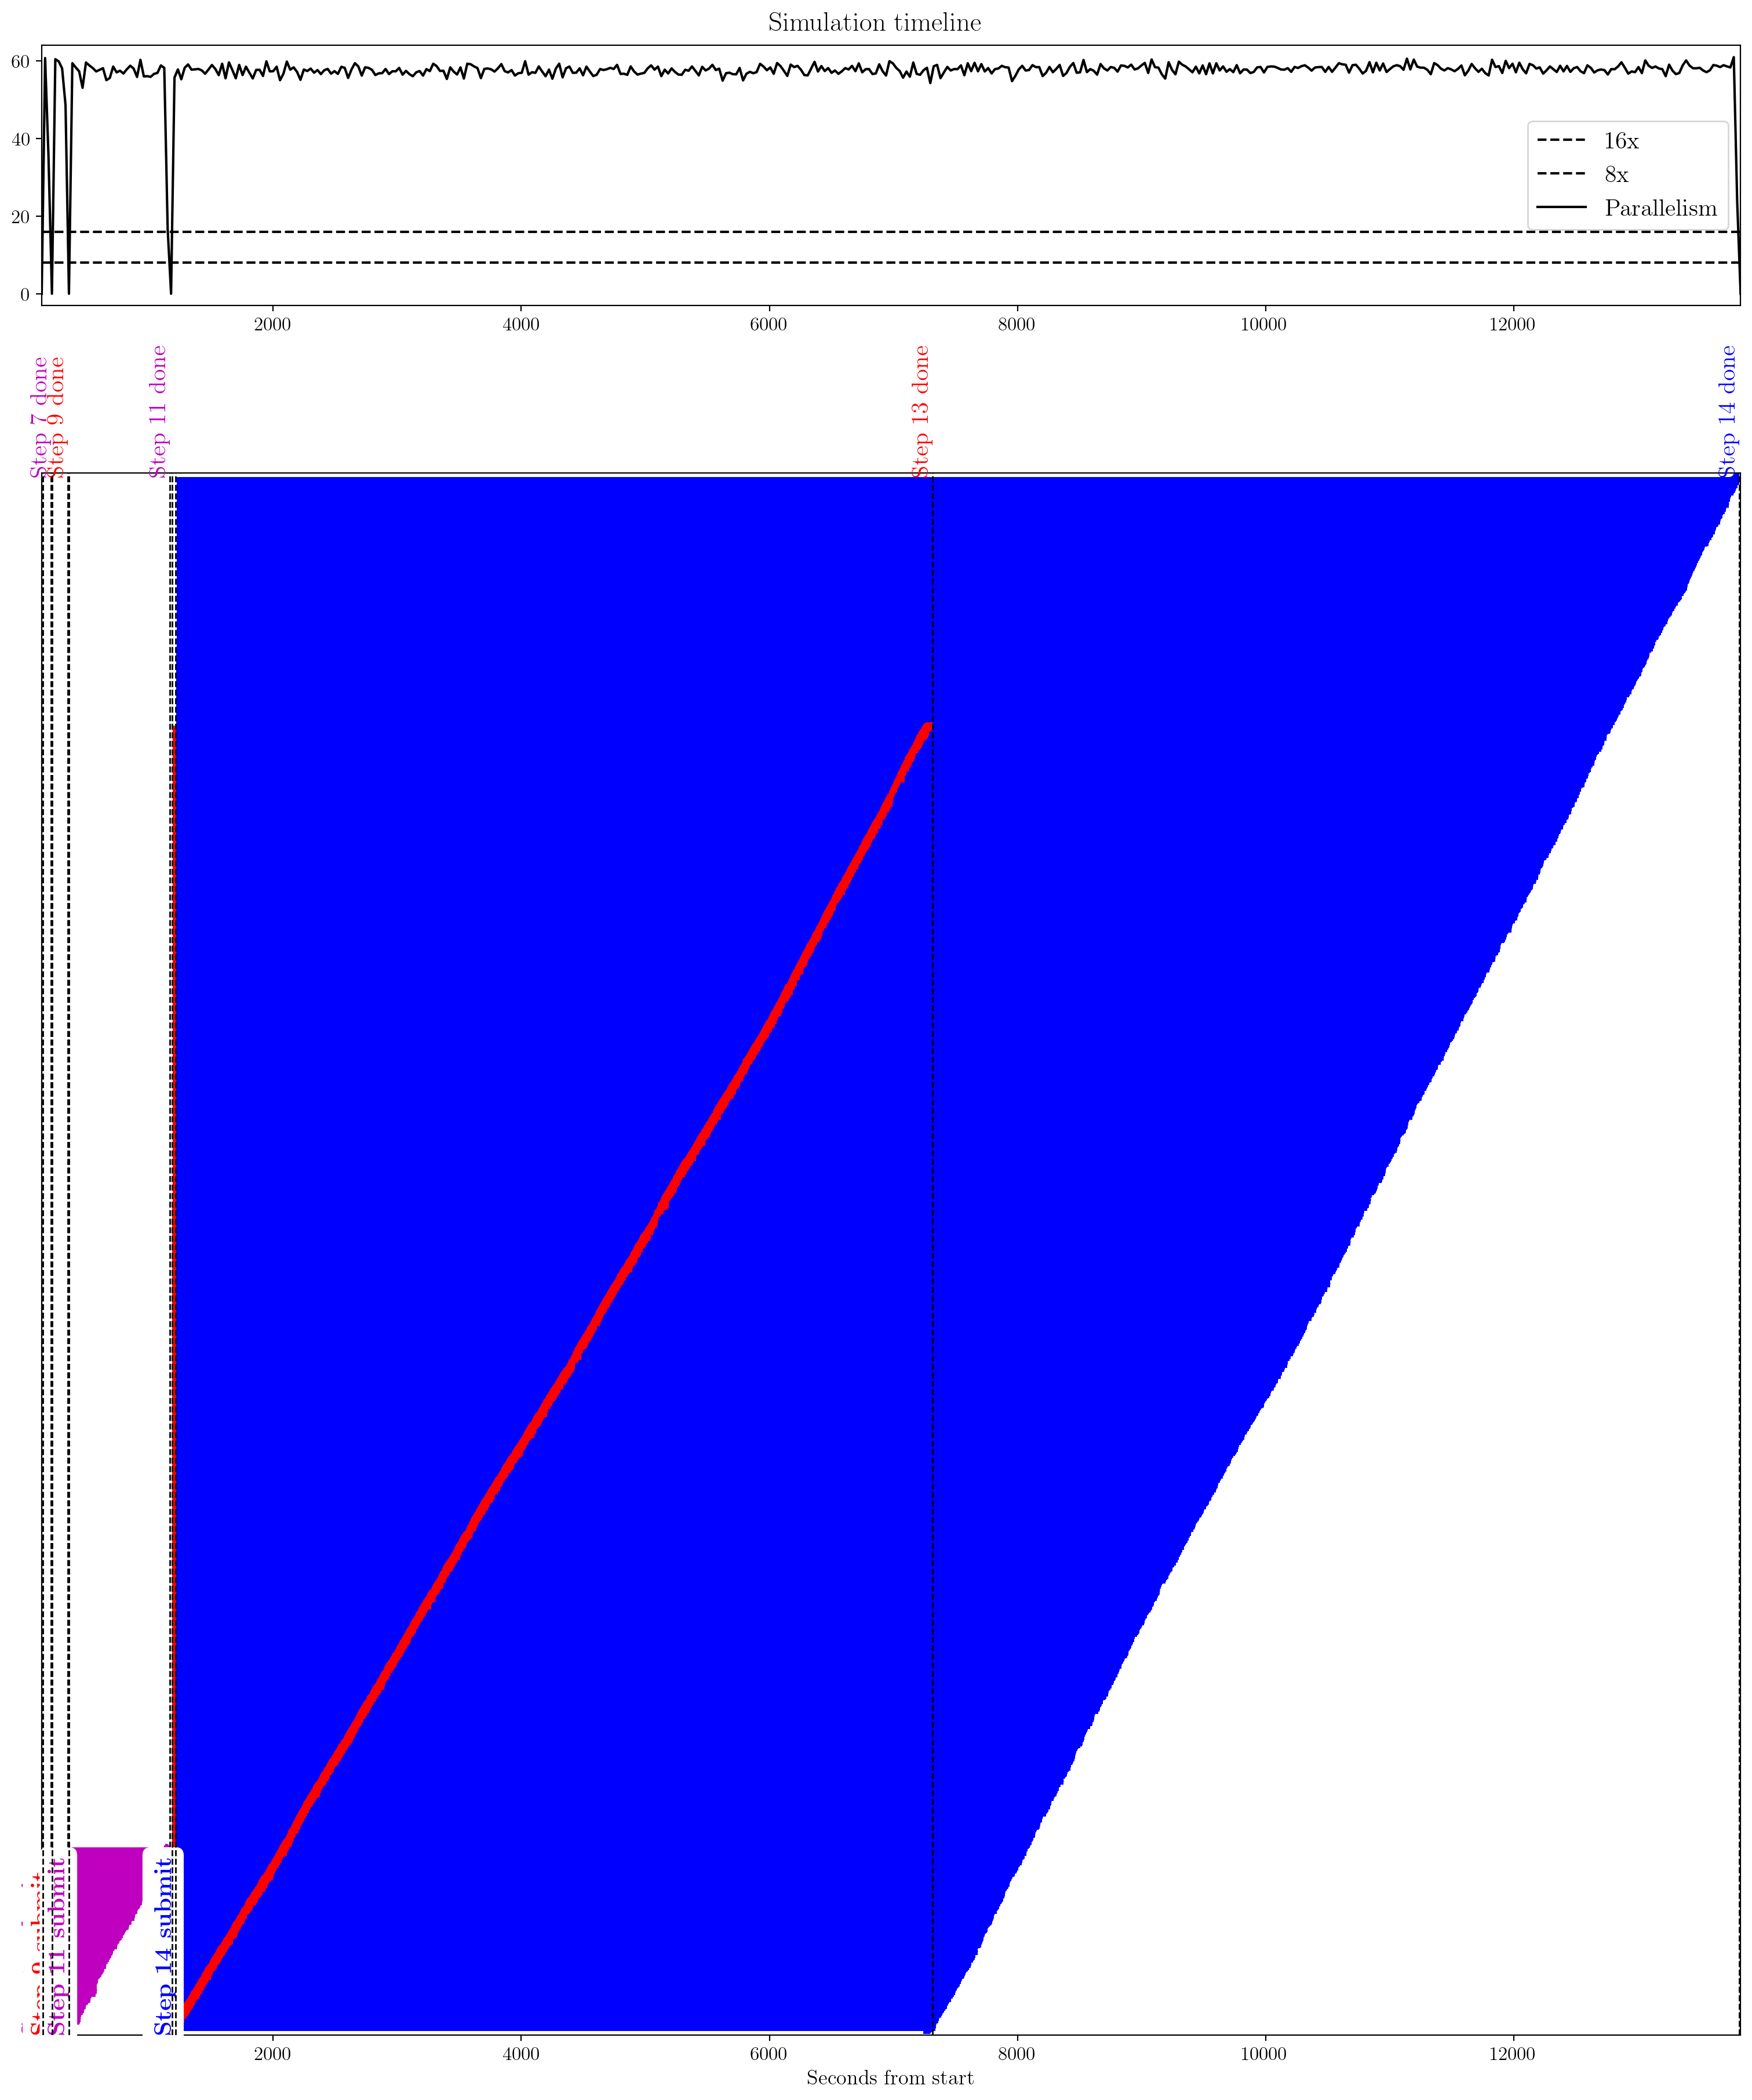

In [9]:

fig = plt.figure(figsize=(15, 18), constrained_layout=True)
plt.suptitle("Simulation timeline")
gs = GridSpec(7, 1, figure=fig)
plt.subplot(gs[0, 0])
ts = np.linspace(min_time, max_time, 500)
ongoing = []
for t in ts:
    ongoing.append(
        (((df["adjusted_sim_start_time"] < t) & (df["adjusted_sim_done_time"] > t)) * df['sims_per_sec']).sum()
    )
ongoing = np.array(ongoing)
max_serial_sims_per_sec = 1e9 / min_runtime_per_sim_ns
plt.axhline(16, color="k", linestyle="--", label="16x")
plt.axhline(8, color="k", linestyle="--", label="8x")
plt.plot(ts, ongoing / max_serial_sims_per_sec, "k-", label="Parallelism")
plt.legend()
plt.xlim([min_time, max_time])

plt.subplot(gs[1:, 0])
plt.eventplot(
    df["positions"].values[:, None],
    lineoffsets="packet_lineoffsets",
    linelengths="packet_linelengths",
    linewidths="packet_linewidths",
    colors="colors",
    orientation="vertical",
    data=df,
)
plt.eventplot(
    df["positions"].values[:, None],
    lineoffsets="lineoffsets",
    linelengths="linelengths",
    linewidths="linewidths",
    colors="colors",
    orientation="vertical",
    data=df,
)

new_step_reports["adjusted_step_start_time"] = (
    new_step_reports["time"] - new_step_reports["runtime_total"] - offset
)
new_step_reports["adjusted_step_done_time"] = new_step_reports["time"] - offset
for step_id in range(min_step, max_step + 1):
    try:
        rpt = new_step_reports.loc[step_id]
    except KeyError:
        continue
    plt.plot(
        [
            rpt["adjusted_step_start_time"],
            rpt["adjusted_step_done_time"],
        ],
        [-1, -1],
        color_list[step_id % len(color_list)],
        linestyle="--",
        linewidth=5,
    )

for step_id, step_df in df.groupby("step_id"):
    plt.axvline(
        step_df["adjusted_start_time"].min(),
        color="k",
        linestyle="--",
        linewidth=1,
        zorder=100,
    )
    plt.axvline(
        step_df["adjusted_done_time"].max(), color="k", linestyle="--", linewidth=1
    )
for step_id, step_df in df.groupby("step_id"):
    plt.text(
        step_df["adjusted_start_time"].min(),
        -3.7,
        "$\\textbf{Step " + str(step_id) + " submit}$",
        rotation=90,
        va="bottom",
        ha="right",
        color=color_list[step_id % len(color_list)],
        bbox=dict(facecolor="w", edgecolor="w", boxstyle="round"),
    )
    plt.text(
        step_df["adjusted_done_time"].max(),
        df["positions"].max() + 0.3,
        f"Step {step_id} done",
        rotation=90,
        va="bottom",
        ha="right",
        color=color_list[step_id % len(color_list)],
    )
plt.xlabel("Seconds from start")
plt.xlim([min_time, max_time])
plt.ylim([-4, df["positions"].max() + 3.5])
plt.gca().get_yaxis().set_visible(False)

plt.show()

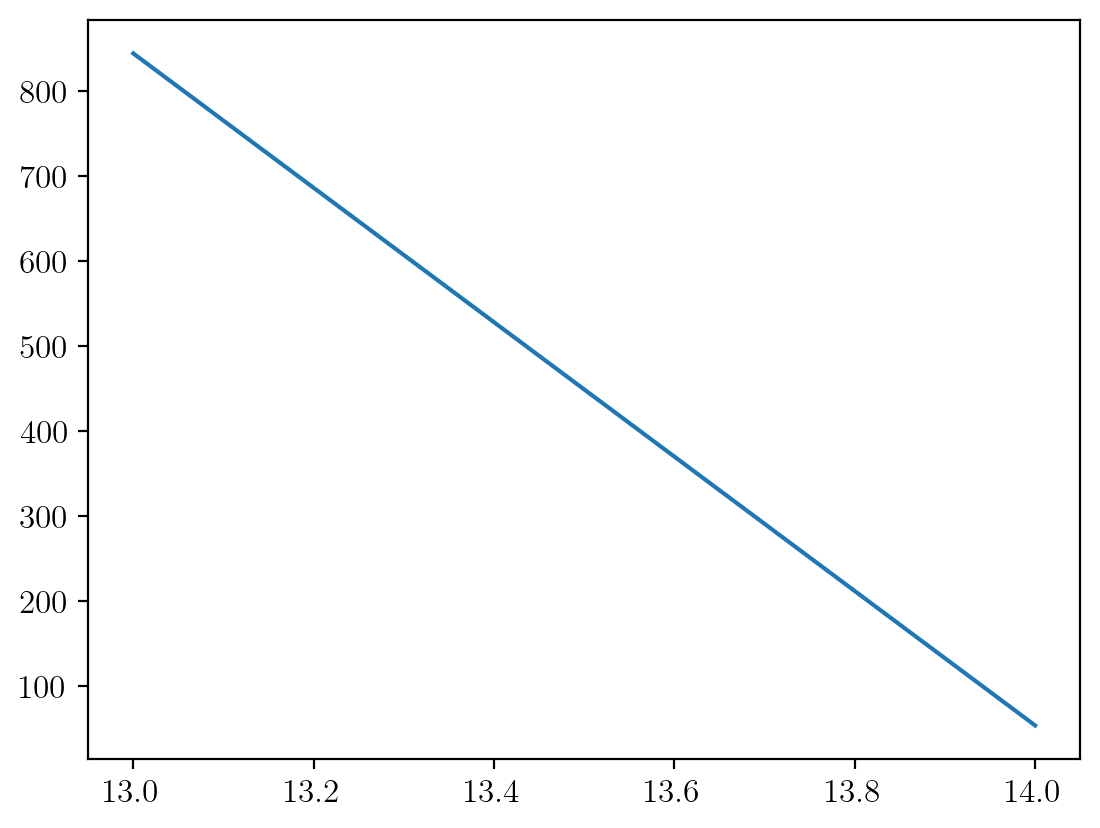

In [10]:
done = df.groupby('step_id')['adjusted_done_time'].max()
start = df.groupby('step_id')['adjusted_start_time'].max()
step_prep_time = start.values[3:] - done.values[1:-2]
plt.plot(done.index[3:], step_prep_time)
plt.show()

In [11]:
parallelism1 = df["n_total_sims"].sum() * min_runtime_per_sim_ns * 1e-9 / (
    df["sim_done_time"].max() - df["sim_start_time"].min()
)

sim_runtime = working_reports["runtime_simulating"].sum()
total_runtime = 2 * (report_df["done_time"].max() - report_df["start_time"].min())
parallelism2 = sim_runtime / total_runtime
parallelism1, parallelism2, sim_runtime / 3600, total_runtime / 3600


(57.25846296566355, 31.31725459239815, 240.38186012175348, 7.675700288878547)

In [12]:
print(working_reports['profile'].iloc[0])

KeyError: 'profile'

## Broad table exploration


In [4]:
n_rows_df = pd.DataFrame(
    [
        (table, query(f"select count(*) from {table}").iloc[0][0])
        for table in ch.all_tables
    ],
    columns=["table", "count"],
).set_index("table")
n_rows_df


2023-04-02 10:36:44,135 - confirm.cloud.clickhouse - DEBUG 
Query took 0.06836795806884766 seconds
select count(*) from results
2023-04-02 10:36:44,162 - confirm.cloud.clickhouse - DEBUG 
Query took 0.02575993537902832 seconds
select count(*) from tiles
2023-04-02 10:36:44,202 - confirm.cloud.clickhouse - DEBUG 
Query took 0.038626670837402344 seconds
select count(*) from done
2023-04-02 10:36:44,223 - confirm.cloud.clickhouse - DEBUG 
Query took 0.02024388313293457 seconds
select count(*) from config
2023-04-02 10:36:44,241 - confirm.cloud.clickhouse - DEBUG 
Query took 0.01830911636352539 seconds
select count(*) from logs
2023-04-02 10:36:44,264 - confirm.cloud.clickhouse - DEBUG 
Query took 0.022297143936157227 seconds
select count(*) from reports
2023-04-02 10:36:44,299 - confirm.cloud.clickhouse - DEBUG 
Query took 0.03430986404418945 seconds
select count(*) from null_hypos


,count
table,
results,182230
tiles,266558
done,96821
config,1
logs,108
reports,4
null_hypos,2


In [35]:
from confirm.adagrid.const import MAX_STEP

n_sims = query("select sum(K) from results").iloc[0][0]
n_retained_sims = query(
    f"select sum(K) from results where inactivation_step={MAX_STEP} and id not in (select id from done where active=false)"
).iloc[0][0]
n_sims / 1e12, n_retained_sims / 1e12


2023-03-31 18:17:43,144 - confirm.cloud.clickhouse - DEBUG 
Query took 0.7327299118041992 seconds
select sum(K) from results
2023-03-31 18:17:44,571 - confirm.cloud.clickhouse - DEBUG 
Query took 1.4261419773101807 seconds
select sum(K) from results where inactivation_step=4294967295 and id not in (select id from done where active=false)


(0.054820593664, 0.052061986816)

In [12]:
n_active_tiles = query(
    f"select count(*) from results where inactivation_step={MAX_STEP}"
).iloc[0][0]
n_eligible_tiles = query(
    f"select count(*) from results where completion_step={MAX_STEP}"
).iloc[0][0]
n_active_tiles, n_eligible_tiles


(9047342, 9047342)

In [13]:
query(
    f"select K, count(*) as n_tiles from tiles where inactivation_step={MAX_STEP} group by K order by K"
)


,K,n_tiles
0,8192,9047342


In [14]:
volume_sql = str(2**dim) + "*" + ("*".join([f"radii{d}" for d in range(dim)]))


In [15]:
smallest_tile = query(
    f"select * from results where inactivation_step={MAX_STEP} order by {volume_sql} limit 1"
)
smallest_tile


,id,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,inactivation_step,orderer,idx,alpha0,impossible,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,B_lams20,B_lams21,B_lams22,B_lams23,B_lams24,B_lams25,B_lams26,B_lams27,B_lams28,B_lams29,B_lams30,B_lams31,B_lams32,B_lams33,B_lams34,B_lams35,B_lams36,B_lams37,B_lams38,B_lams39,B_lams40,B_lams41,B_lams42,B_lams43,B_lams44,B_lams45,B_lams46,B_lams47,B_lams48,B_lams49,completion_step
0,7216444109899956816,7216444088425363824,-1.278125,-1.278125,-1.540625,-1.465625,0.009375,0.009375,0.009375,0.009375,True,False,8192,8,100,4294967295,0.018769,165,0.020362,False,0.023907,0.022191,0.018769,0.022446,0.02096,0.021841,0.022981,0.02189,0.024064,0.021409,0.023852,0.019823,0.022981,0.023344,0.021841,0.019471,0.021409,0.023852,0.021841,0.021179,0.020103,0.021959,0.019309,0.024023,0.023134,0.021409,0.023773,0.021764,0.019823,0.020301,0.024524,0.019823,0.021469,0.024872,0.022446,0.023134,0.021841,0.021409,0.023852,0.021469,0.023907,0.019823,0.021841,0.020103,0.022446,0.02309,0.023134,0.022983,0.023653,0.02288,0.023784,0.02309,0.023907,0.02323,4294967295


In [16]:
largest_tile = query(
    f"select * from results where inactivation_step={MAX_STEP} order by {volume_sql} desc limit 1"
)
largest_tile


,id,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,inactivation_step,orderer,idx,alpha0,impossible,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,B_lams20,B_lams21,B_lams22,B_lams23,B_lams24,B_lams25,B_lams26,B_lams27,B_lams28,B_lams29,B_lams30,B_lams31,B_lams32,B_lams33,B_lams34,B_lams35,B_lams36,B_lams37,B_lams38,B_lams39,B_lams40,B_lams41,B_lams42,B_lams43,B_lams44,B_lams45,B_lams46,B_lams47,B_lams48,B_lams49,completion_step
0,7216443418409613232,7216443409819852304,-1.2125,-1.2125,-1.8125,-1.3625,0.0375,0.0375,0.0375,0.0375,True,False,8192,3,76,4294967295,0.009171,85,0.010568,False,0.01327,0.01098,0.009171,0.010991,0.01026,0.010991,0.010991,0.011029,0.011754,0.010195,0.011548,0.008472,0.010991,0.011754,0.011155,0.009379,0.009379,0.011548,0.011054,0.010195,0.010122,0.010456,0.008853,0.01327,0.011029,0.009923,0.011054,0.011548,0.010195,0.009923,0.012576,0.011155,0.011548,0.011754,0.010928,0.012407,0.011054,0.011054,0.011054,0.009171,0.011548,0.009946,0.010991,0.010122,0.010928,0.010404,0.012188,0.012282,0.01026,0.011155,0.012169,0.011054,0.01327,0.010122,4294967295


In [17]:
n_possible_tiles = query("select count(*) from results where isNotNull(lams)").iloc[0][
    0
]
n_possible_tiles


CatalogException: Catalog Error: Scalar Function with name isnotnull does not exist!
Did you mean "isnan"?

In [18]:
lamss_tile = query(
    f"""
select * from results 
    where inactivation_step={MAX_STEP} 
        and isNotNull(lams) 
    order by lams 
    limit 1
"""
)
lamss_tile


CatalogException: Catalog Error: Scalar Function with name isnotnull does not exist!
Did you mean "isnan"?

In [19]:
lamss = lamss_tile["lams"].iloc[0]


NameError: name 'lamss_tile' is not defined

2023-03-30 15:27:09,001 - confirm.cloud.clickhouse - DEBUG 
Query took 0.038573265075683594 seconds

select lams from results 
    where inactivation_step=4294967295 
        and lams <= nan



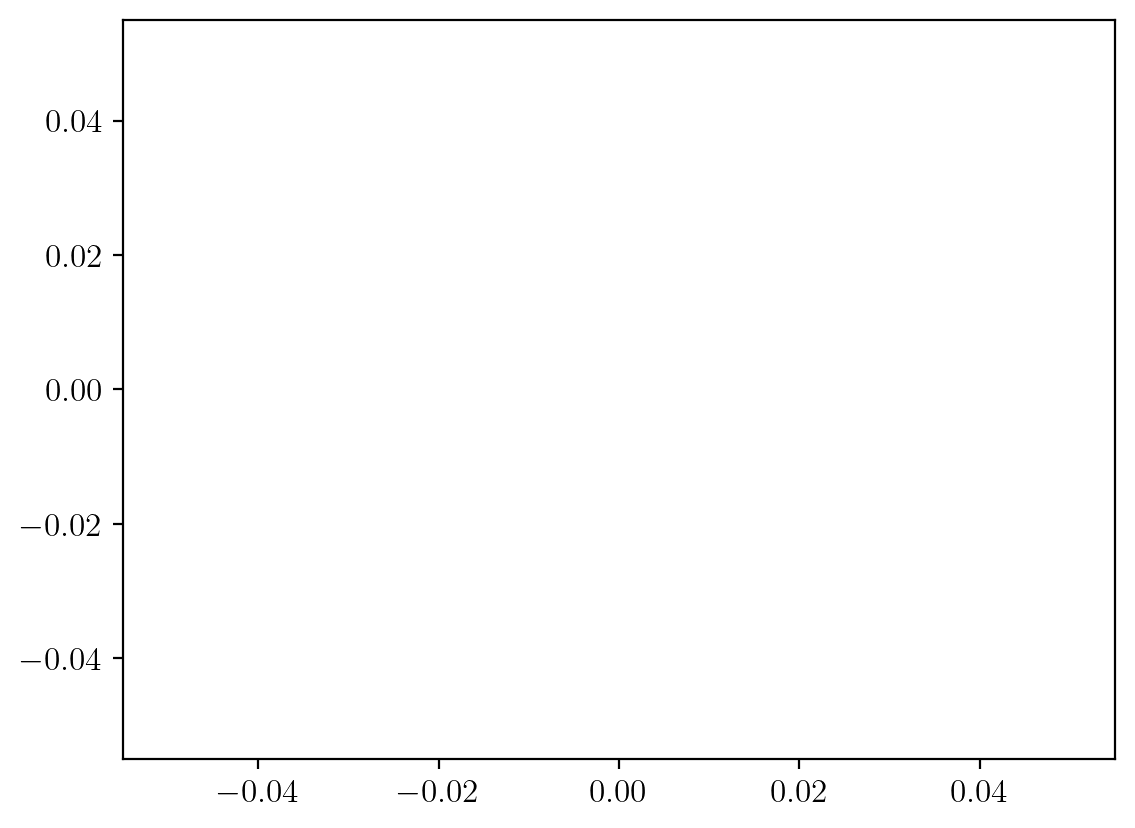

In [115]:
lams = query(
    f"""
select lams from results 
    where inactivation_step={MAX_STEP} 
        and lams <= {lamss}
"""
)
max_display = lamss * 2
plt.hist(lams["lams"], bins=np.linspace(lamss, max_display, 100))
plt.show()


## Ordering


In [21]:
worst5000_df = self.con.query(
    "select * from results where inactivation_step>10000 order by lams limit 5000"
).df()


In [22]:
orderer_df = self.con.query(
    f"select orderer from results where inactivation_step>10000 and orderer <= {worst5000_df['orderer'].max()} order by orderer"
).df()


In [23]:
wait = np.searchsorted(orderer_df["orderer"], worst5000_df["orderer"])
wait


array([     0,      0,      0,      0,      0,      0,      0,      0,      0,     45, ..., 151702,
       151702, 151702,  63950,  63950,  63950,  63950,  63950,  63950,  95159])

In [15]:
cfg = self.get_config().iloc[0].to_dict()


In [47]:
import confirm.adagrid.calibrate as adacal
import confirm.models.wd41 as wd41

report = dict()
algo = adacal.AdaCalibrate(
    wd41.WD41(0, 600000, ignore_intersection=True), None, self, cfg, None
)


In [48]:
tiles_df = self.next(10, 11, 50000, "orderer")
twb_worst_tile = self.worst_tile(10, "twb_mean_lams")
# np.sum(tiles_df['twb_min_lams'] > twb_worst_tile['twb_mean_lams'].iloc[0])


In [51]:
self = algo
twb_worst_tile = self.db.worst_tile(10, "twb_mean_lams")
for col in twb_worst_tile.columns:
    if col.startswith("radii"):
        twb_worst_tile[col] = 1e-6
twb_worst_tile["K"] = self.max_K
twb_worst_tile_lams = self.driver.bootstrap_calibrate(
    twb_worst_tile,
    self.cfg["alpha"],
    calibration_min_idx=self.cfg["calibration_min_idx"],
    tile_batch_size=1,
)
twb_worst_tile_mean_lams = twb_worst_tile_lams["twb_mean_lams"].iloc[0]
deepen_likely_to_work = tiles_df["twb_min_lams"] > twb_worst_tile_mean_lams


In [53]:
np.sum(deepen_likely_to_work)


0

## Looking at the reports


In [19]:
runtime_mins = (working_reports['done_time'].max() - working_reports['start_time'].min()) / 60
runtime_mins

230.2710086663564

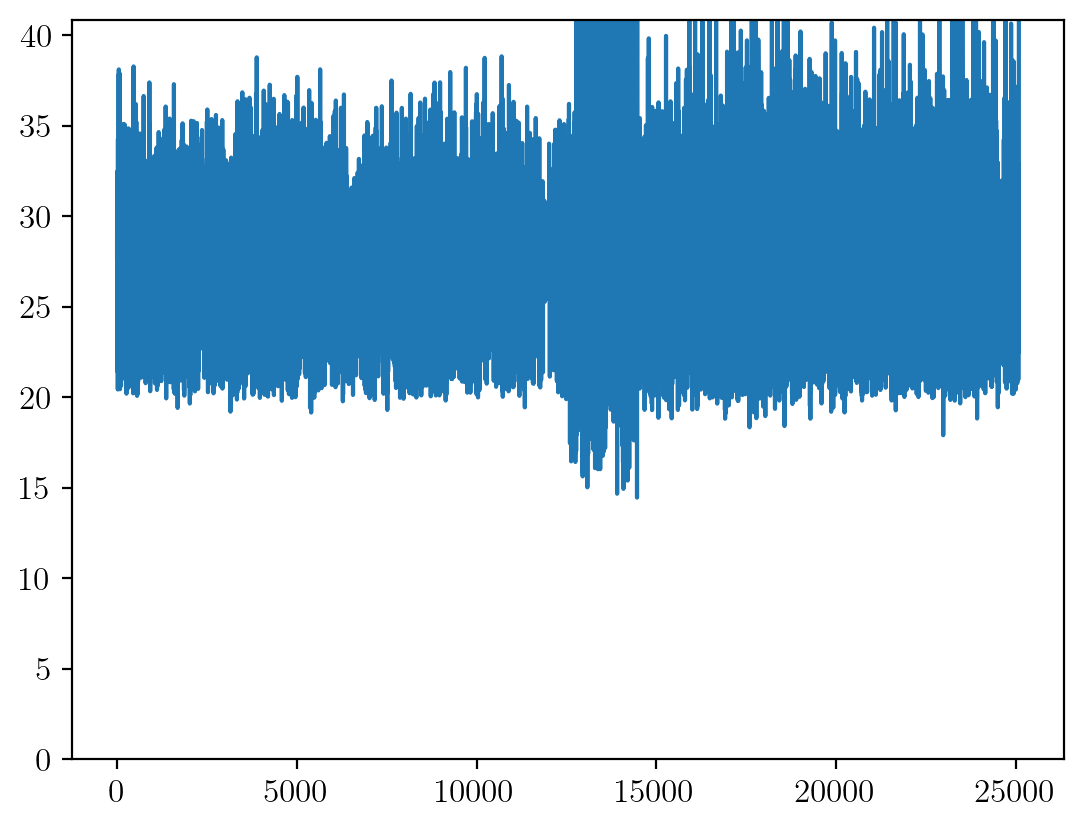

In [20]:
plt.plot(working_reports["runtime_per_sim_ns"])
plt.ylim([0, np.percentile(working_reports["runtime_per_sim_ns"], 99.5)])
plt.show()


In [21]:
working_reports["runtime_simulating"].sum()


865374.6964383125

In [22]:
new_step_reports

,bias_tie,std_tie,spread_tie,grid_cost,lamss,min(B_lamss),max(B_lamss),tie_{k}(lamss),tie + slack,converged,runtime_convergence_criterion,start_time,status,basal_step_id,runtime_total,n_impossible,n_refine,n_deepen,n_complete,time,n_new_tiles,n_new_sims,n_packets
step_id,,,,,,,,,,,,,,,,,,,,,,,
1,0.000046,0.000624,0.003357,0.011718,0.005212,0.004553,0.006092,0.013245,0.025008,False,0.000000e+00,1.680766e+09,NEW_STEP,0.0,7.782153,0.0,1561.0,7603.0,0.0,1.680766e+09,32579.0,1.316684e+09,2.0
3,0.000027,0.000799,0.004761,0.006575,0.008785,0.007719,0.010141,0.018372,0.024974,False,0.000000e+00,1.680766e+09,NEW_STEP,1.0,0.574785,0.0,6154.0,31174.0,0.0,1.680766e+09,129638.0,6.025839e+09,6.0
5,0.000016,0.000534,0.002029,0.006557,0.008951,0.008355,0.009452,0.018417,0.024991,False,0.000000e+00,1.680766e+09,NEW_STEP,3.0,0.885551,0.0,11388.0,166679.0,0.0,1.680766e+09,348887.0,2.199526e+10,21.0
7,-0.000020,0.000545,0.001999,0.003630,0.011185,0.010544,0.011701,0.021347,0.024957,False,0.000000e+00,1.680766e+09,NEW_STEP,5.0,0.831974,0.0,31634.0,402070.0,0.0,1.680766e+09,908214.0,8.295029e+10,78.0
9,0.000025,0.000259,0.001152,0.006716,0.009105,0.008733,0.009364,0.018284,0.025024,False,0.000000e+00,1.680766e+09,NEW_STEP,7.0,1.337365,0.0,6512.0,1165269.0,0.0,1.680766e+09,1269461.0,2.458289e+11,229.0
11,0.000033,0.000201,0.001047,0.006680,0.009840,0.009463,0.010061,0.018316,0.025030,False,0.000000e+00,1.680766e+09,NEW_STEP,9.0,0.870343,0.0,150746.0,1143965.0,0.0,1.680766e+09,3555901.0,1.590404e+12,1482.0
13,0.000009,0.000209,0.001129,0.003682,0.011428,0.011071,0.011589,0.021315,0.025006,False,9.536743e-07,1.680767e+09,NEW_STEP,11.0,1.457796,0.0,1309578.0,782748.0,0.0,1.680767e+09,21735996.0,1.139592e+13,10614.0
14,0.000009,0.000209,0.001129,0.003682,0.011428,0.011071,0.011589,0.021315,0.025006,False,0.000000e+00,1.680767e+09,NEW_STEP,12.0,1.322724,0.0,1596781.0,329696.0,0.0,1.680767e+09,25878192.0,1.356763e+13,12636.0
15,0.000029,0.000211,0.000996,0.001914,0.012717,0.012303,0.012934,0.023077,0.025020,True,0.000000e+00,1.680773e+09,CONVERGED,13.0,0.335235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
new_step_reports['n_deepen'].sum() / 1e6

4.029204

In [25]:
new_step_reports['n_refine'].sum() / 1e6

3.114354

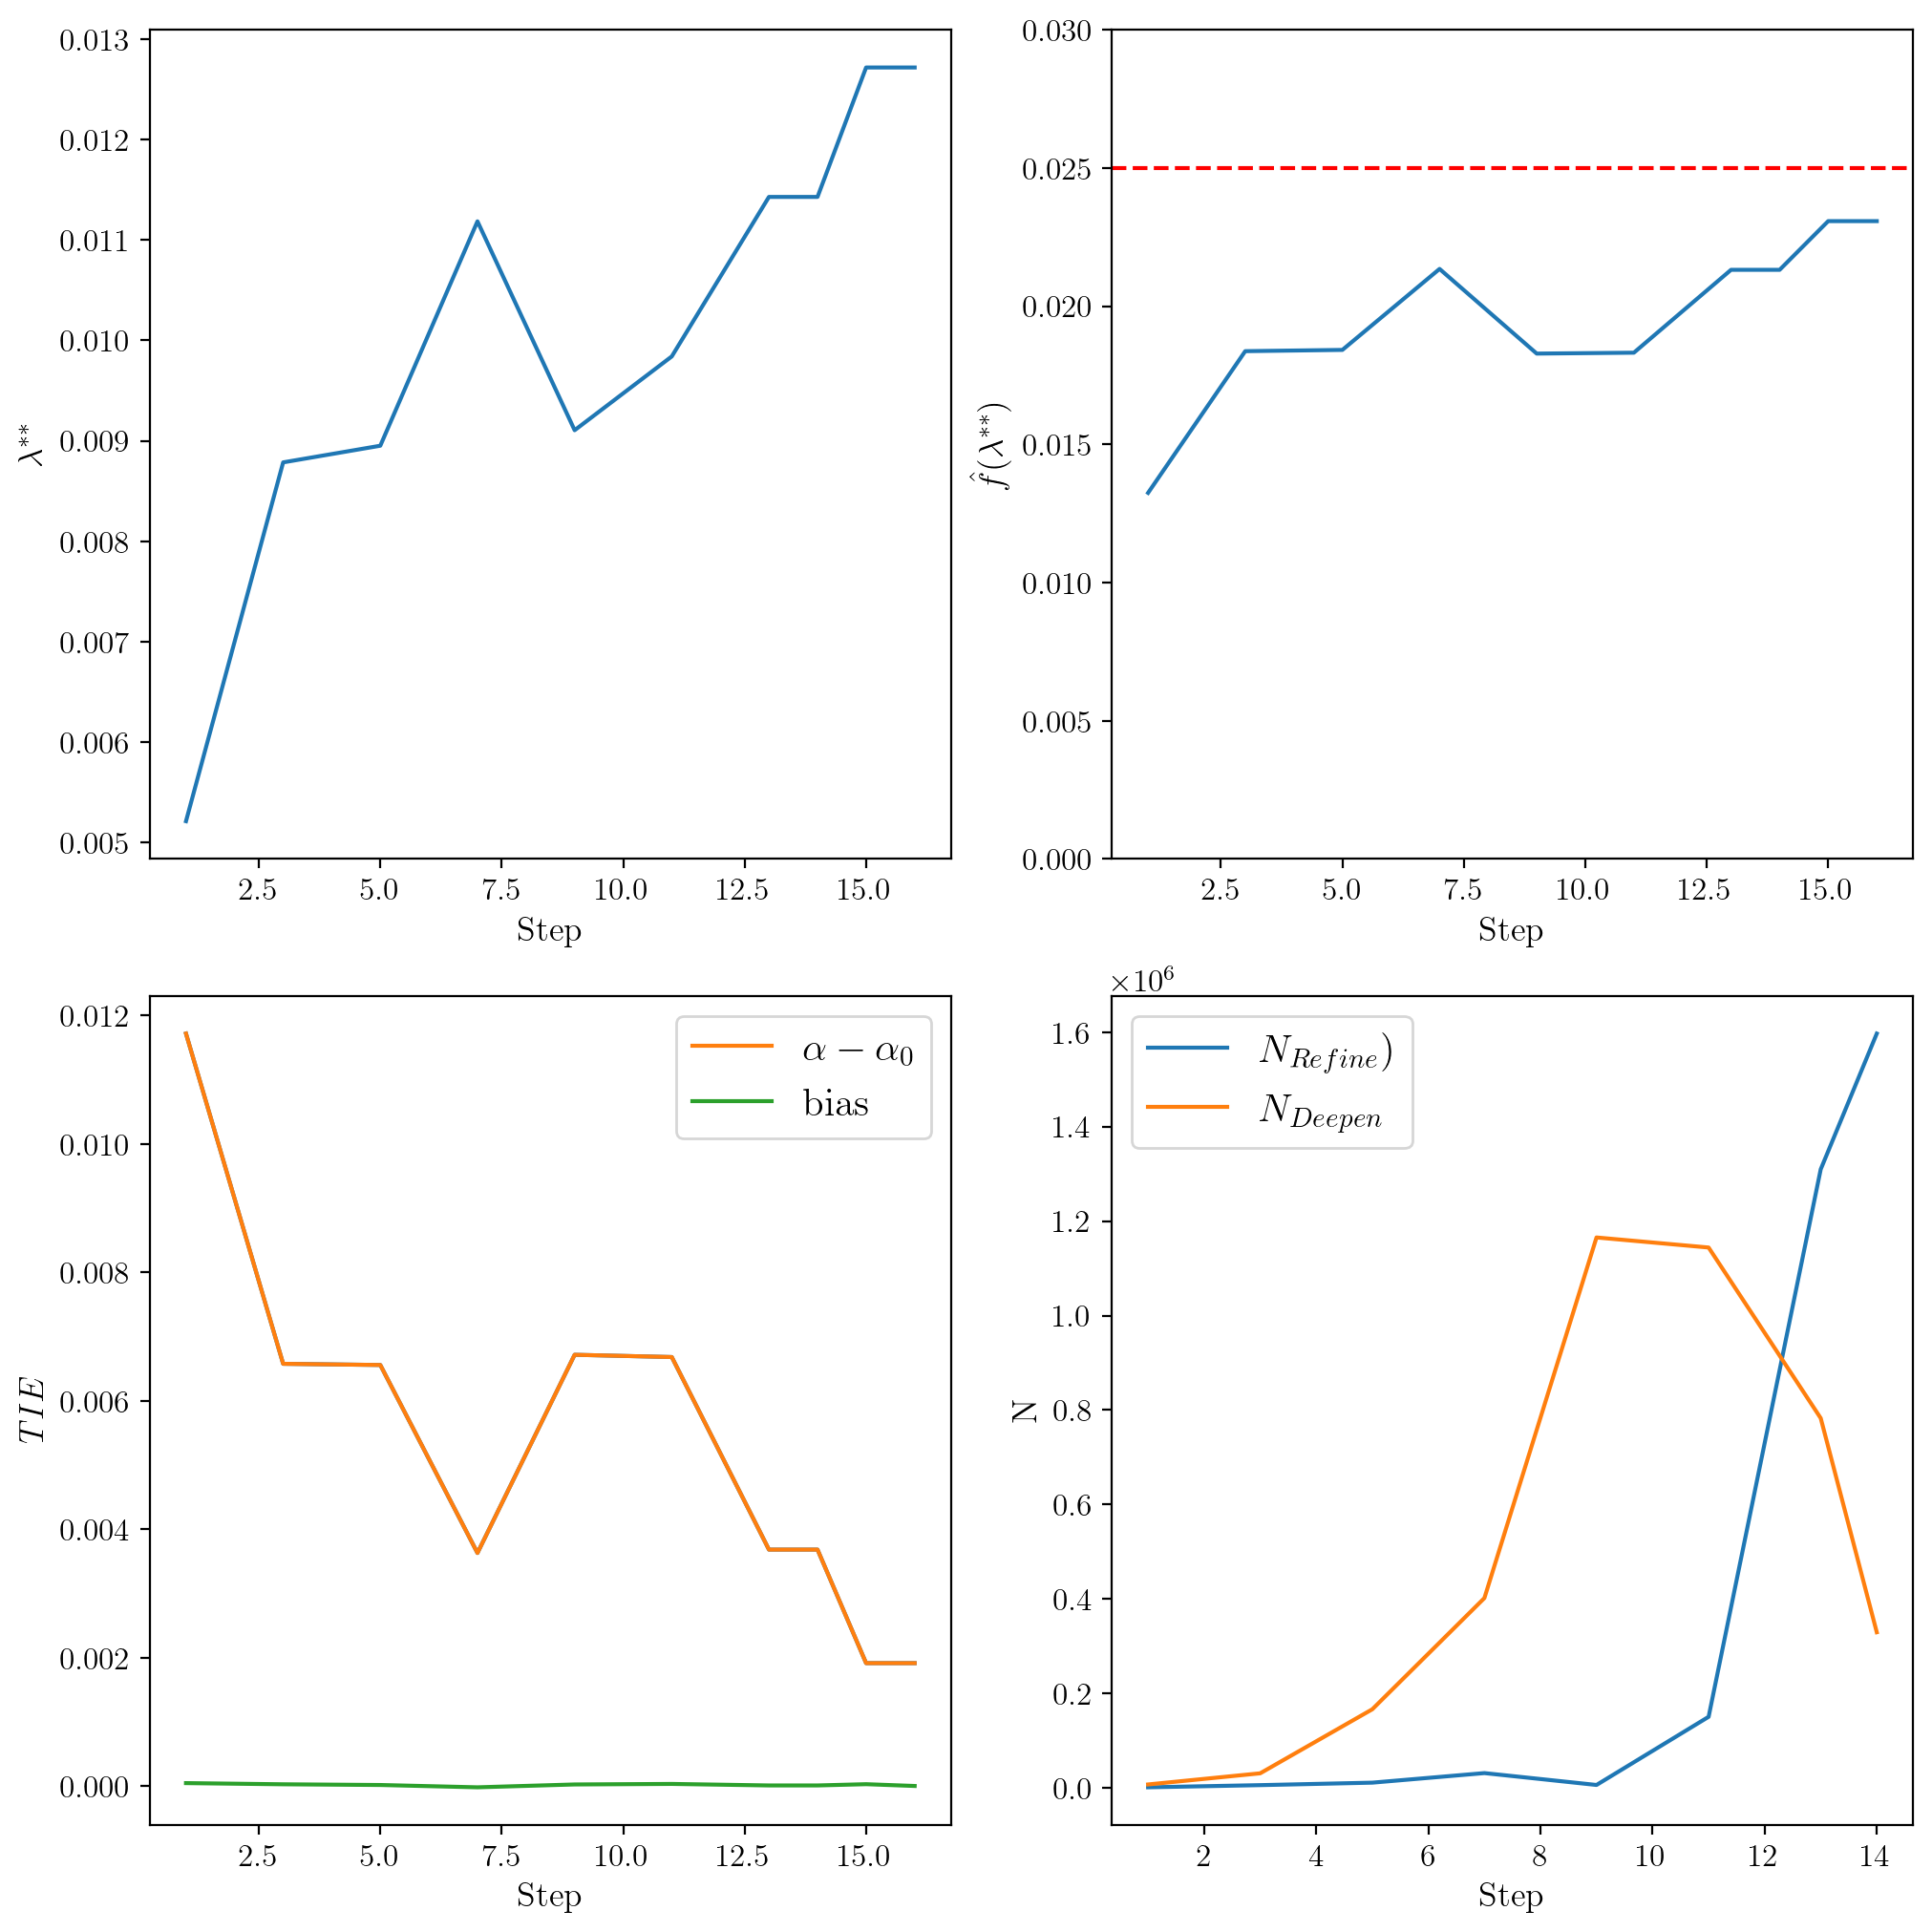

In [23]:
plt.figure(figsize=(10, 10), constrained_layout=True)
plt.subplot(2,2,1)
plt.plot(new_step_reports["lamss"])
plt.xlabel("Step")
plt.ylabel("$\lambda^{**}$")
plt.subplot(2,2,2)
plt.plot(new_step_reports["tie_{k}(lamss)"])
plt.axhline(0.025, color="red", linestyle="--")
plt.xlabel("Step")
plt.ylabel("$\hat{f}(\lambda^{**})$")
plt.ylim([0, 0.03])

plt.subplot(2,2,3)
plt.plot(new_step_reports["grid_cost"])
plt.xlabel("Step")
plt.ylabel(r"$\alpha - \alpha_0$")

plt.subplot(2,2,3)
plt.plot(new_step_reports["grid_cost"], label=r'$\alpha - \alpha_0$')
plt.plot(new_step_reports["bias_tie"], label="bias")
plt.legend()
plt.xlabel("Step")
plt.ylabel(r"$TIE$")

plt.subplot(2,2,4)
plt.plot(new_step_reports["n_refine"], label='$N_{Refine}$)')
plt.plot(new_step_reports["n_deepen"], label="$N_{Deepen}$")
plt.legend()
plt.xlabel("Step")
plt.ylabel("N")
plt.show()

In [19]:
import numpy as np

xs = np.linspace(-2, 1, 10)
ys = np.linspace(-2, 1, 10)
counts = np.empty((len(xs), len(ys)))
for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        NN = self.con.query(
            f"""
            select count(*) 
                from results
                where 
                    inactivation_step={MAX_STEP}
                    and abs(theta0 - {x}) < 0.167
                    and abs(theta2 - {y}) < 0.167
        """
        ).fetchone()[0]
        counts[i, j] = NN


In [20]:
counts.sum() / 1e6


61.254279

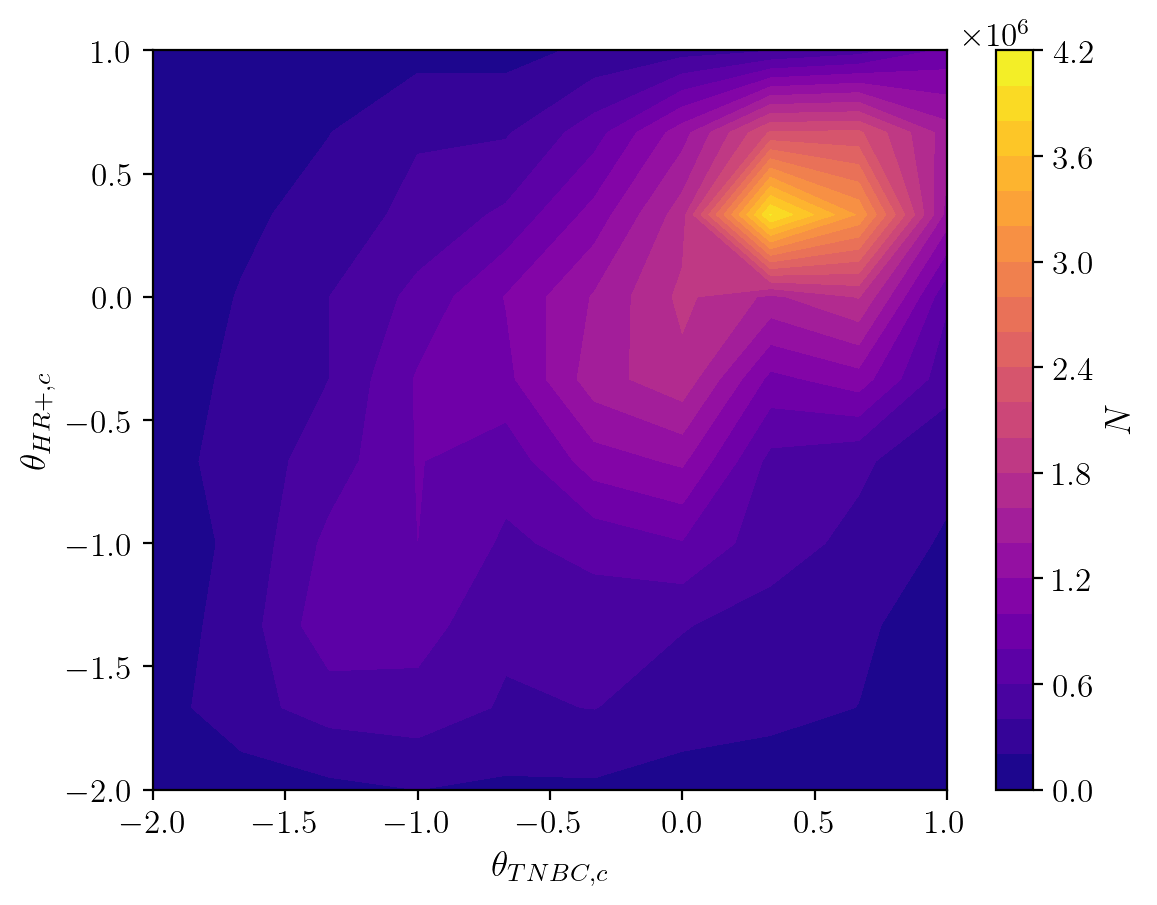

In [21]:
XX, YY = np.meshgrid(xs, ys, indexing="ij")
# plt.scatter(XX.ravel(), YY.ravel(), c=counts.ravel())
plt.contourf(XX, YY, counts, levels=20)
plt.xlabel("$\\theta_{TNBC, c}$")
plt.ylabel("$\\theta_{HR+, c}$")
cbar = plt.colorbar()
cbar.set_label("$N$")
plt.show()


In [22]:
plot_df = self.con.query(
    """
    select theta0, theta1, theta2, theta3, 
            radii0, radii1, radii2, radii3, 
            alpha0, K, lams, twb_mean_lams, twb_min_lams 
        from results
        where 
            abs(theta0 + 1) < 0.05
            and abs(theta2 + 1) < 0.05
"""
).df()


In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(plot_df["theta1"], plot_df["theta3"], c=plot_df["K"], s=5)
plt.colorbar()
plt.subplot(2, 2, 2)
plt.scatter(plot_df["theta1"], plot_df["theta3"], c=plot_df["alpha0"], s=5)
plt.colorbar()
plt.subplot(2, 2, 3)
plt.scatter(plot_df["theta1"], plot_df["theta3"], c=plot_df["lams"], s=5)
plt.colorbar()
plt.subplot(2, 2, 4)
plt.scatter(plot_df["theta1"], plot_df["theta3"], c=plot_df["twb_min_lams"], s=5)
plt.colorbar()
plt.show()
